In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

sns.set(context='notebook', style='white', font_scale=1.2)

In [2]:
try:
    import crossmapy as cmp
except:
    import sys
    sys.path.append('../')
    import crossmapy as cmp

In [3]:
res_dir = f'results/gene/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

In [5]:
import matplotlib as mpl
import networkx as nx

testArrow = mpl.patches.ArrowStyle.Fancy(head_length=.4, head_width=.4, tail_width=.1)
testArrow = mpl.patches.ArrowStyle.BracketB(widthB=.3, lengthB=.0)

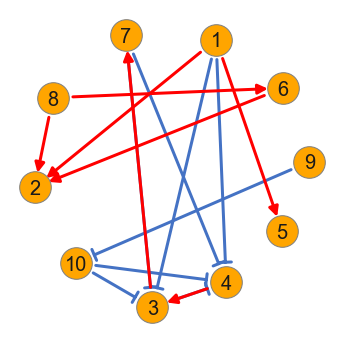

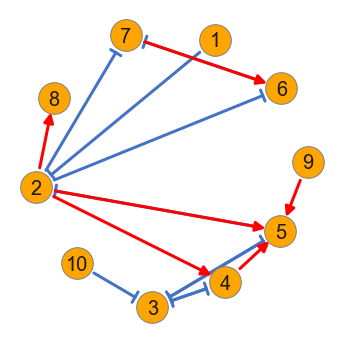

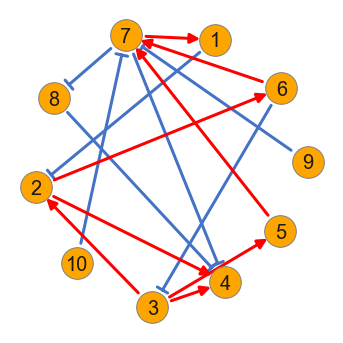

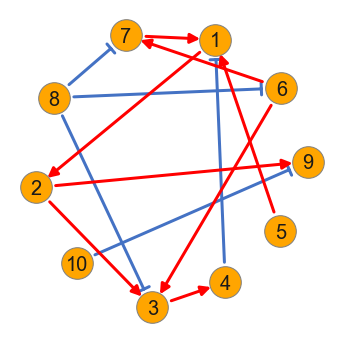

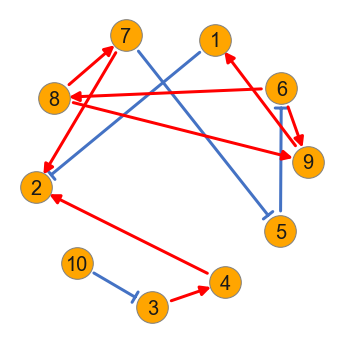

In [6]:
# n_nold = 10
for i in range(1, 6):
    n_nold = 10
    with open(f'../data/gene/net{i}_truth.tsv', 'r') as f:
        rdata = f.readlines()
        edges_pos = []
        edges_neg = []
        for row in rdata:
            # print(row.strip('\n').split('\t'))
            g1, g2, flag = row.strip('\n').split('\t')
            gn1 = int(g1[1:])
            gn2 = int(g2[1:])
            if flag == '+':
                edges_pos.append([gn1, gn2])
            else:
                edges_neg.append([gn1, gn2])


    G = nx.DiGraph()
    G.add_nodes_from(np.arange(1, n_nold + 1))
    pos = nx.spring_layout(G, seed=1)

    fig, ax = plt.subplots(figsize=(5, 5))
    nx.draw_networkx_nodes(G, pos, node_size=1000, edgecolors='gray', node_color='orange', ax=ax)

    # edges'#4472C4'
    nx.draw_networkx_edges(G, pos, edgelist=edges_pos, width=3, edge_color='#4472C4',
                           arrowsize=20, connectionstyle='arc3,rad=0.0', arrowstyle=testArrow,
                           min_target_margin=20, min_source_margin=20, ax=ax, alpha=1)
    nx.draw_networkx_edges(
        G, pos, edgelist=edges_neg, width=3, edge_color='#FF0000', style="-", arrowsize=20,
        connectionstyle='arc3,rad=0.0', arrowstyle='-|>', min_target_margin=15, min_source_margin=20, ax=ax,
        alpha=1
    )

    # labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif", verticalalignment='center_baseline', ax=ax)
    ax.margins(0.05)
    plt.axis("off")
    plt.tight_layout()

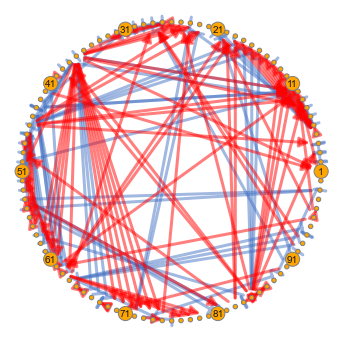

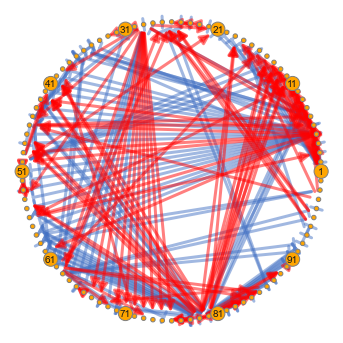

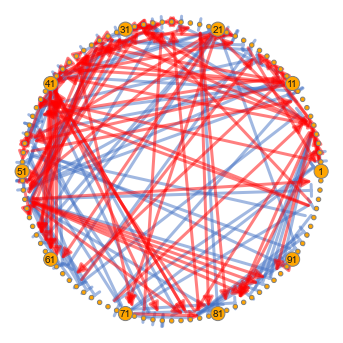

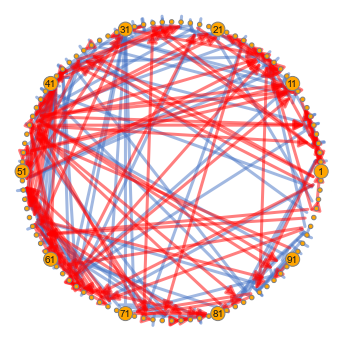

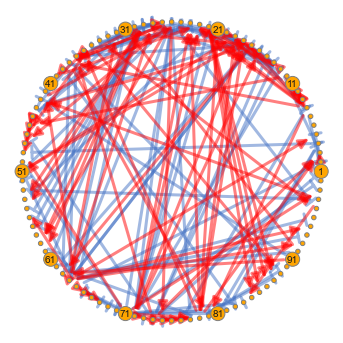

In [7]:
# n_nold = 100
for i in range(6, 11):
    n_nold = 100
    with open(f'../data/gene/net{i}_truth.tsv', 'r') as f:
        rdata = f.readlines()
        edges_pos = []
        edges_neg = []
        for row in rdata:
            # print(row.strip('\n').split('\t'))
            g1, g2, flag = row.strip('\n').split('\t')
            gn1 = int(g1[1:])
            gn2 = int(g2[1:])
            if flag == '+':
                edges_pos.append([gn1, gn2])
            else:
                edges_neg.append([gn1, gn2])

    G = nx.DiGraph()
    G.add_nodes_from(np.arange(1, n_nold + 1))
    pos = nx.circular_layout(G)

    node_size = np.ones(n_nold) * 20
    node_size[::10] = 200
    min_source_margin = 0
    min_target_margin = 0
    fig, ax = plt.subplots(figsize=(5, 5))

    nx.draw_networkx_nodes(G, pos, node_size=node_size, edgecolors='gray', node_color='orange', ax=ax)

    nx.draw_networkx_edges(G, pos, edgelist=edges_pos, width=3, edge_color='#4472C4',
                           arrowsize=20, connectionstyle='arc3,rad=0.0', arrowstyle=testArrow,
                           min_target_margin=min_target_margin, min_source_margin=min_source_margin, ax=ax, alpha=.5)
    nx.draw_networkx_edges(
        G, pos, edgelist=edges_neg, width=3, edge_color="#FF0000", style="-", arrowsize=20,
        connectionstyle='arc3,rad=0.0', arrowstyle='-|>', min_target_margin=min_target_margin,
        min_source_margin=min_source_margin, ax=ax,
        alpha=.5
    )

    nx.draw_networkx_labels(G, pos, labels={n: (n if n%10==1 else '') for n in G}, font_size=10, font_family="sans-serif", verticalalignment='center_baseline', ax=ax)
    ax.margins(0.0)
    plt.axis("off")
    plt.tight_layout()

In [13]:
def main(net):
    embed_dim = 9
    
    GC = cmp.GrangerCausality(embed_dim=embed_dim)
    TE = cmp.TransferEntropy(embed_dim=embed_dim)
    CCM = cmp.ConvergeCrossMapping(embed_dim=embed_dim)
    PCM = cmp.PartialCrossMapping(embed_dim=embed_dim)
    CMC = cmp.CrossMappingCardinality(embed_dim=embed_dim)
    DCMC = cmp.DirectCrossMappingCardinality(embed_dim=embed_dim)
    
    methods = [GC, TE, CCM, PCM, CMC, DCMC]
    labels = ['GC', 'TE', 'CCM', 'PCM', 'CMC', 'DCMC']

    data = np.load(f'../data/gene/net{net}_expression.npy')

    res_dir = f'results/gene/'
    for i, method in enumerate(methods):
        method.fit(data)
        result = cmp.skip_diag_tri(method.scores).ravel()
        np.save(f'{res_dir}net{net}_method{labels[i]}.npy', result)
        print(f'net{net} method {labels[i]} complete!')

In [ ]:
for net in range(1, 11):
    main(net)

In [25]:
embed_dim = 9
net = 5
tlabels = [f'{i+1}' for i in range(10)]
tick_bin = 1
linewidths = 1
n_nold = 10

truth_data = pd.read_csv(f'../data/gene/net{net}_truth.tsv', delimiter='\s+', header=None)
truth_data.iloc[:, :2] = truth_data.iloc[:, :2].apply(lambda x: [int(v.split('G')[1]) for v in x])
edges_truth = truth_data[[0, 1]].values.astype('int')
gold_mat = cmp.edges_to_mat(edges_truth - 1, n_nold)
truths = cmp.skip_diag_tri(gold_mat).ravel()

<AxesSubplot:>

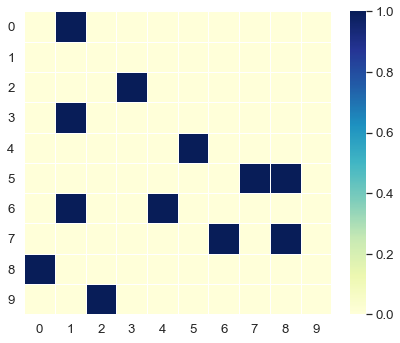

In [28]:
cmp.plot_score_matrix(gold_mat, annot=False)

In [35]:
labels = ['CCM', 'PCM', 'DCMC']

res = []
for label in labels:
    path = f'{res_dir}net{net}_method{label}.npy'
    tmp_dat = np.load(path)
    res.append(tmp_dat)

In [36]:
fpr_list, tpr_list = [], []
for i, v in enumerate(labels):
    fpr, tpr, _ = metrics.roc_curve(truths, res[i])
    fpr_list.append(fpr)
    tpr_list.append(tpr)

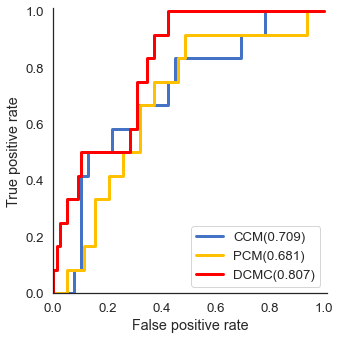

In [37]:
fig, ax = cmp.plot_mul_roc_curve(fpr_list, tpr_list, labels=labels, colors=['#4472C4', '#FFC000', '#FF0000'],
                                 xlabel='False positive rate', ylabel='True positive rate', lw=3,
                                 diag_line=False)
sns.despine(ax=ax)
ax.set_xlim(0, 1.01)
ax.set_ylim(0, 1.01)
ax.grid()

In [38]:
labels = ['GC', 'TE', 'CCM', 'PCM', 'CMC', 'DCMC']
    
auroc_list = []
for net in range(1, 11):
    if net > 5:
        tlabels = [f'{i+1}' for i in range(0, 100, 10)]
        tick_bin = 10
        linewidths = 0
        n_nold = 100
    else:
        tlabels = [f'{i+1}' for i in range(10)]
        tick_bin = 1
        linewidths = 1
        n_nold = 10

    truth_data = pd.read_csv(f'../data/gene/net{net}_truth.tsv', delimiter='\s+', header=None)
    truth_data.iloc[:, :2] = truth_data.iloc[:, :2].apply(lambda x: [int(v.split('G')[1]) for v in x])
    edges_truth = truth_data[[0, 1]].values.astype('int')
    gold_mat = cmp.edges_to_mat(edges_truth - 1, n_nold)
    truths = cmp.skip_diag_tri(gold_mat).ravel()

    res = []
    for label in labels:
        path = f'{res_dir}net{net}_method{label}.npy'
        tmp_dat = np.load(path)
        res.append(tmp_dat)

    fpr_list, tpr_list = [], []
    for i, v in enumerate(labels):
        fpr, tpr, _ = metrics.roc_curve(truths, res[i])
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auroc = metrics.auc(fpr, tpr)
        auroc_list.append([net, n_nold, v, auroc])

In [41]:
auroc_df = pd.DataFrame(auroc_list, columns=['Net', 'Nolds', 'Method', 'AUROC'])
auroc_df.to_csv(f'{res_dir}/auroc_df.csv', index=False)

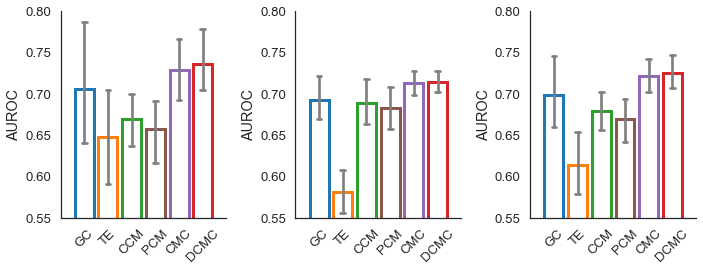

In [43]:
clist = ['#1f77b4', '#ff7f0e', '#2ca02c', '#8c564b', '#9467bd', '#d62728', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0] = sns.barplot(x="Method", y="AUROC", data=auroc_df[auroc_df.Nolds==10], ax=ax[0],
                    capsize=.2, facecolor=(1, 1, 1, 0), edgecolor=clist, linewidth=3, errcolor='gray')
ax[1] = sns.barplot(x="Method", y="AUROC", data=auroc_df[auroc_df.Nolds==100], ax=ax[1],
                    capsize=.2, facecolor=(1, 1, 1, 0), edgecolor=clist, linewidth=3, errcolor='gray')
ax[2] = sns.barplot(x="Method", y="AUROC", data=auroc_df, ax=ax[2],
                    capsize=.2, facecolor=(1, 1, 1, 0), edgecolor=clist, linewidth=3, errcolor='gray')
for i in range(3):
    ax[i].set_ylim(0.55, 0.8)
    ax[i].set_xlim(-1, 6)
    sns.despine(ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(labels, rotation=45)
plt.tight_layout()

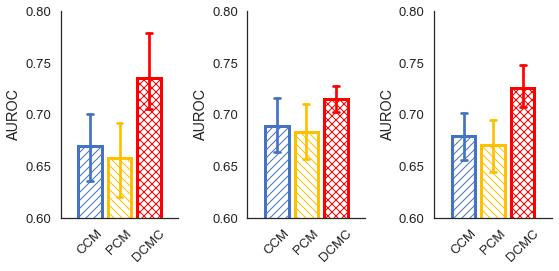

In [44]:
clist3 = ['#4472C4', '#FFC000', '#FF0000']
auroc_df2 = auroc_df[(auroc_df.Method=='CCM')|(auroc_df.Method=='PCM')|(auroc_df.Method=='DCMC')]
fig, ax = plt.subplots(1, 3, figsize=(8, 4))
ax[0] = sns.barplot(x="Method", y="AUROC", data=auroc_df2[auroc_df2.Nolds==10], ax=ax[0],
                    capsize=.2, facecolor=(1, 1, 1, 0), edgecolor=clist3, linewidth=3, errcolor='gray')
ax[1] = sns.barplot(x="Method", y="AUROC", data=auroc_df2[auroc_df2.Nolds==100], ax=ax[1], #fill=True, hatch='///',
                    capsize=.2, facecolor=(1, 1, 1, 0), edgecolor=clist3, linewidth=3, errcolor='gray')
ax[2] = sns.barplot(x="Method", y="AUROC", data=auroc_df2, ax=ax[2],
                    capsize=.2, facecolor=(1, 1, 1, 0), edgecolor=clist3, linewidth=3,
                    errcolor='.3'
                    )

for i in range(3):
    ax[i].set_ylim(0.6, 0.8)
    ax[i].set_xlim(-1, 3)
    sns.despine(ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(['CCM', 'PCM', 'DCMC'], rotation=45)
    for j, h in enumerate(['///', "\\\\\\", 'xxx']):
        p = ax[i].patches[j]
        p.set_hatch(h)
        # p.set_width(0.6)
    for j, l in enumerate(ax[i].lines):
        idx = j // 3
        l.set_color(clist3[idx])

plt.tight_layout()